# Imports

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
from skimage.morphology import erosion
from skimage.morphology import disk
from skimage.filters import prewitt
import math
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from skimage import color, io, measure, segmentation, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.color import label2rgb
from scipy.spatial import distance
from skimage.transform import rotate
from skimage.transform import EuclideanTransform
from skimage.transform import warp
from skimage.transform import matrix_transform
from exam_functions import *
from sklearn import decomposition
from sklearn.decomposition import PCA

# Fall 2021

Text(0.5, 1.0, 'Varianza Cumulativa Spiegata')

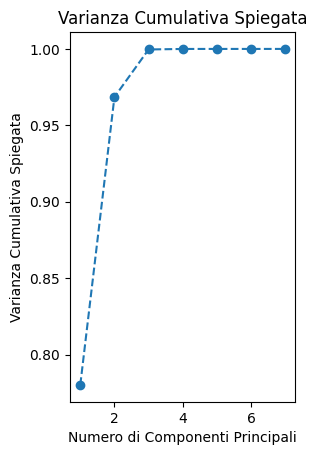

In [29]:
# 1
in_dir = "Exams/dec2021/"
pizza_data = np.loadtxt(
    r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\Exams\dec2021\PCAData\pizza.txt",
    comments="%",
)
x = pizza_data[0:300, 0:7]
data = x  # deve essere di tipo numpy, non gli va bene un panda dataframe
pca = PCA(n_components=7)
pca_model = pca.fit(data)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
# Plot della varianza cumulativa
plt.subplot(1, 2, 2)
plt.plot(
    range(1, len(exp_var_ratio) + 1),
    np.cumsum(exp_var_ratio),
    marker="o",
    linestyle="--",
)
plt.xlabel("Numero di Componenti Principali")
plt.ylabel("Varianza Cumulativa Spiegata")
plt.title("Varianza Cumulativa Spiegata")

In [36]:
pca.mean_

array([40.90306667, 13.37356667, 20.22953333,  2.63323333,  0.6694    ,
       22.86476667,  3.271     ])

In [37]:
pc1 = pca_model.components_[0]
pc2 = pca_model.components_[1]

# new pizza is generated as 3 * principal component 1 + means of the features
feature_means = pca.mean_
new_pizza = 3 * pc1 + feature_means

print(new_pizza)

[40.07217639 12.57274229 19.39273266  2.46693105  0.63597518 25.49901976
  3.26919014]


In [51]:
from PIL import Image
import numpy as np
import os

# Load the images
in_dir = r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\Exams\dec2021\ImagePCA"
image_files = [f for f in os.listdir(in_dir) if f.endswith(".png")]

images = []
for img_file in image_files:
    img_path = os.path.join(in_dir, img_file)
    img = Image.open(img_path).convert("L")  # Convert images to grayscale
    images.append(img)

# Convert the list of images to a NumPy array
images = np.array([np.array(img) for img in images])

# Compute the average image
average_image = np.mean(images, axis=0).astype(np.uint8)

# Apply thresholding
threshold_value = 150
thresholded_image = np.where(average_image > threshold_value, 255, 0).astype(np.uint8)

# Display or save the resulting image
result_image = Image.fromarray(thresholded_image)
result_image.show()
# result_image.save('resulting_image.png')  # Save the resulting image if needed

533 400 3


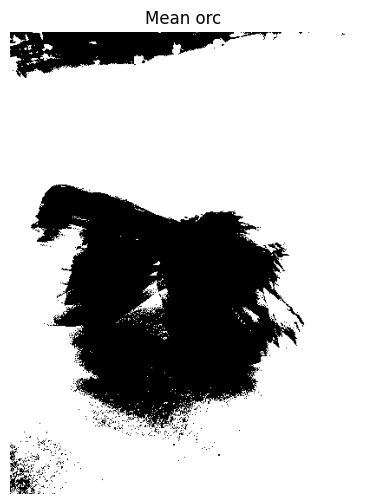

In [102]:
# 3
in_dir = "C:/Users/Dell/Desktop/Git Hub/02502-Image-Analysis-Cheatsheet/Exams/dec2021/ImagePCA"

files = glob.glob(f"{in_dir}/*.png")

height, width, channels = io.imread(files[0]).shape
print(height, width, channels)

data_matrix = np.zeros((len(files), height * width * 3))
for i, f in enumerate(files):
    # print(f)
    # f_g = color.rgb2gray(f)
    data_matrix[i, :] = io.imread(f).flatten()
    # print(data_matrix[i, :])

# print(data_matrix)
average_img = np.mean(data_matrix, axis=0)

mask = average_img > 150
img_ = img_as_ubyte(mask)
average_cat_img = create_u_byte_image_from_vector(img_, height, width, 3)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.imshow(average_cat_img)
ax.set_title("Mean orc")
ax.set_axis_off()
plt.show()

In [94]:
# 4
orc_pca = PCA()
orc_pca.fit(data_matrix)

# Assuming 'data_matrix' contains your data and 'orc_pca' is already fitted
first_principal_component = orc_pca.components_[
    0
]  # Retrieve the first principal component

# Reshape the first principal component into an image
image_shape = (533, 400, 1)  # Assuming the original image shape
first_pc_image = first_principal_component.reshape(image_shape)
first_pc_image[10, 10]

ValueError: cannot reshape array of size 639600 into shape (533,400,1)

# DEC 2022


## 1


1. Reads the DICOM image
2. Uses the annotated regions to extract pixel values in the liver, kidney and aorta
   regions
3. Determines two threshold using minimum distance classification. Threshold
   number (t1) separates the liver and the kidney. The second threshold (t2)
   separates the kidney and the aorta.
4. Segments the DICOM image by setting all pixel that have a value >t1 and <t2 to
   foreground and the rest to background.
5. Computes the DICE score between the resulting segmented image and the
   KidneyROI.png image.


In [2]:
in_dir = "Exams/dec2022/data/"
im_name = "dicom/1-162.dcm"
ct = dicom.read_file(in_dir + im_name)
img = ct.pixel_array

In [4]:
liver_roi = io.imread(in_dir + "LiverROI.png")
liver_mask = liver_roi > 0
liver_values = img[liver_mask]
kidney_roi = io.imread(in_dir + "KidneyROI.png")
kidney_mask = kidney_roi > 0
kidney_values = img[kidney_mask]
aorta_roi = io.imread(in_dir + "AortaROI.png")
aorta_mask = aorta_roi > 0
aorta_values = img[aorta_mask]
# print(f"liver: {liver_values}\nkidney: {kidney_values}\naorta: {aorta_values}")

In [5]:
mu_liver = np.mean(liver_values)
mu_kidney = np.mean(kidney_values)
mu_aorta = np.mean(aorta_values)

t_liver_kidney = (mu_liver + mu_kidney) / 2
t_kidney_aorta = (mu_kidney + mu_aorta) / 2
print(t_liver_kidney, t_kidney_aorta)

135.53619417264818 196.7035801627044


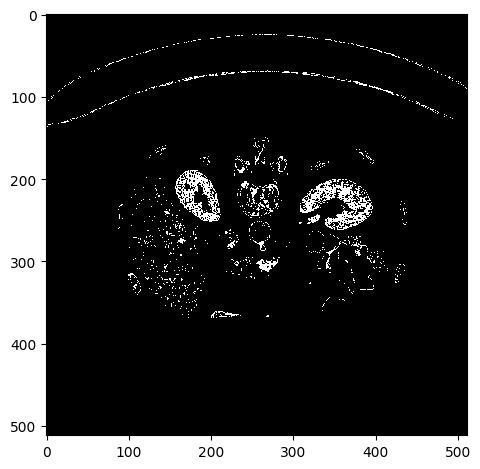

In [6]:
kidney_img = (img > t_liver_kidney) & (img < t_kidney_aorta)
io.imshow(kidney_img)
io.show()

In [9]:
dice_score = 1 - distance.dice(kidney_img.ravel(), kidney_roi.ravel())
print(f"DICE score {dice_score:.3f}")

DICE score 0.241


## 2


The five data points (x, y):

(7,13), (9,10), (6,10), (6,8), (3,6)

result in the corresponding five Hough space sinograms (curves in Hough space) shown below.

Two Hough space sinograms are crossing at (rho = 0.29, theta = 151 ).

What are the corresponding data points for the two crossing curves in Hough space? (approximately)


In [4]:
convert_xy_to_hough(0.29, 151, [7, 9, 6, 6, 3])

Approximate data points in the xy-plane:
(7, 13.23)
(9, 16.83)
(6, 11.42)
(6, 11.42)
(3, 6.01)


## 3


We are searching for the shortest path going from the top to the bottom
of the image below.

You are using dynamic programming for the task
and as part of that you are computing an accumulator image.

What is the
minimal value of the last row of the computed accumulator image?


In [5]:
print(f"minimal value = {19 + 23 + 17 + 18 + 44}")

minimal value = 121


## 4


In [3]:
integral_value = [33, 12, 110, 200, 53, 81, 220, 120, 107]

integral_image(integral_value)

INTEGRAL IMAGE = 936


## 5


1. Converts the input image from RGB to gray scale and transforms it into a floating
   point image.
2. Does a linear gray scale transformation so the transformed image has a minimum
   pixel value of 0.1 and a maximum pixel value of 0.6
3. Computes a pixel value threshold using Otsu's method
4. Applies the found threshold, so all pixels with values above the threshold
   becomes foreground (white) and the rest background (black)


0.3724609375


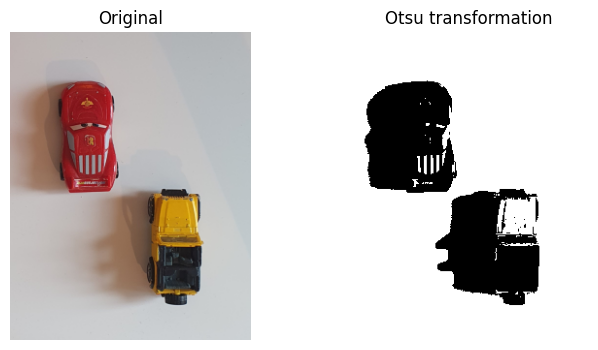

In [5]:
def func5():
    img_path = "Exams\dec2022\data\PixelWiseOps\pixelwise.png"

    im_1 = io.imread(img_path)

    grey_img = color.rgb2gray(im_1)

    transf_img = linear_gray_scale_transformation(grey_img, 0.1, 0.6)

    tresh = threshold_otsu(transf_img)

    print(tresh)
    img_otsu = transf_img > tresh

    show_comparison(im_1, img_otsu, "Otsu transformation")


func5()

## 6


You would like to make a cool black and white illustration of a rocket.

To do that you filter the image (rocket.png) with a Prewitt filter.

Secondly, you threshold the filtered image, so all pixels with a value above 0.06
become white and the rest black.

How many white pixels are there in the
resulting image?


In [ ]:
rocket = io.imread(
    r"C:\Users\Dell\Desktop\Git Hub\02502-Image-Analysis-Cheatsheet\Exams\dec2022\data\Filtering\rocket.png"
)


img_prewitt = prewitt(img_as_ubyte(rocket))


# show_comparison(rocket, img_prewitt, "title")


bin_edges = img_prewitt > 0.06
io.imshow(bin_edges)
io.show()


num_pixels = bin_edges.sum()


print(f"Number of edge pixels {num_pixels}")

In [ ]:
io.imshow(rocket)
io.show()
print("data type = ", rocket.dtype)

# complete prewitt
img_prewitt = prewitt(rocket)
print("data type = ", img_prewitt.dtype)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(rocket, cmap="gray")
ax[1].imshow(img_prewitt, cmap="gray", vmin=0, vmax=1)
plt.show()

filtered = img_prewitt > 0.06
print(filtered.dtype)

io.imshow(filtered)
# Utilizza numpy.unique per ottenere valori unici e i loro conteggi
valori_unici, conteggi = np.unique(filtered, return_counts=True)

# Stampa valori unici e i loro conteggi
for valore, conteggio in zip(valori_unici, conteggi):
    print(f"Valore: {valore}, Conteggio: {conteggio}")

## 7


In [24]:
import numpy as np

# Dati forniti
x = np.array([23, 5])
mu_1 = np.array([24, 3])
mu_2 = np.array([30, 7])
sigma = np.array([[2, 0], [0, 2]])

# Calcolo del vettore peso w
sigma_inv = np.linalg.inv(sigma)
w = np.dot(sigma_inv, (mu_2 - mu_1))

# Calcolo della soglia cw
cw = 1 - 0.5 * np.dot(np.dot(((mu_1 + mu_2).T), sigma_inv), (mu_2 - mu_1))

# Calcolo di y_c in 2
y_c_in_2 = np.dot(x.T, w) + cw

print(f"y = {y_c_in_2} e cw = {cw}")

# Determinazione della classe di appartenenza
if y_c_in_2 > 0:
    print(f"Il punto {x} appartiene alla Classe 2")
else:
    print(f"Il punto {x} appartiene alla Classe 1")

y = -11.0 e cw = -90.0
Il punto [23  5] appartiene alla Classe 1


In [19]:
# Dati forniti
x = np.array([23, 5])
mu_1 = np.array([24, 3])
mu_2 = np.array([30, 7])
sigma = np.array([[2, 0], [0, 2]])

# Calcolo del vettore peso w
sigma_inv = np.linalg.inv(sigma)
w = np.dot(sigma_inv, (mu_2 - mu_1))

# Calcolo della soglia cw
cw = 0.5 * (
    np.dot(np.dot(mu_1.T, sigma_inv), mu_1) - np.dot(np.dot(mu_2.T, sigma_inv), mu_2)
)

cw = 1 - 0.5 * np.dot(np.dot(((mu_1 + mu_2).T), sigma_inv), (mu_2 - mu_1))

# Calcolo di y_c in 2
y_c_in_2 = np.dot(x.T, w) + cw
print(f"y = {y_c_in_2} e cw = {cw}")

# Determinazione della classe di appartenenza
if y_c_in_2 > cw:
    print(f"Il punto {x} appartiene alla Classe 2")
else:
    print(f"Il punto {x} appartiene alla Classe 1")

y = -11.0 e cw = -90.0
Il punto [23  5] appartiene alla Classe 2


## 8


You have been asked by a farmer to develop a machine vision system that can detect if
a cow or a sheep is passing by a camera.

The camera just measure the average intensity of the image of the animal. To train your system, the farmer has given you these measured training data measured on 10 cows and 12 sheep:

Cows = [26, 46, 33, 23, 35, 28, 21, 30, 38, 43]

Sheep = [67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100]

First, you try to compute the intensity threshold dividing cows and sheep using a
minimum distance classifier.

Secondly, you fit Gaussians to the two sets of the data to do a parametric classification.


In [106]:
cows = [26, 46, 33, 23, 35, 28, 21, 30, 38, 43]
sheeps = [67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100]

mu_cow = np.mean(cows)
mu_sheep = np.mean(sheeps)

min_dist = (mu_cow + mu_sheep) / 2

from scipy.stats import norm

# Fit Gaussian distributions to cows and sheep data
cows_mean, cows_std = norm.fit(cows)
sheep_mean, sheep_std = norm.fit(sheeps)

# Calculate PDF values at value=38 for cows and sheep distributions
value = 38
pdf_cows = norm.pdf(value, cows_mean, cows_std)
pdf_sheep = norm.pdf(value, sheep_mean, sheep_std)

print(f"PDF value for cows at value=38: {pdf_cows}")
print(f"PDF value for sheep at value=38: {pdf_sheep}")

PDF value for cows at value=38: 0.03898570495862376
PDF value for sheep at value=38: 0.016687527843330045
